![header](images/header.png)

# Calibration
<!-- [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ec-jrc/lisflood-usecases/mekong_usecase?urlpath=%2Fdoc%2Ftree%2FLF_mekong_usecase%2Fdocs%2Fnotebooks%2F) -->

<br>
<br>
<br>

So far, we have developed a LISFLOOD model than runs and it is correctly initialized. However, we are using default model parameters, so there's no confidence at all in the accuracy of the model. Before you can extract any conclusions from your model results, the model needs to be calibrated. As a result of the calibration, the model parameters are tuned so that the outputs reproduce observed data as good as possible. Calibration is usually performed on the river discharge timeseries at one or more gauging stations, but there are plenty of other calibration strategies. 

To perform a calibration, LISFLOOD proposes a [calibration tool](https://github.com/ec-jrc/lisflood-calibration) based on DEAP (Distributed Evolutionary Algorithms in Python) ([Fortin et al., 2012](https://www.jmlr.org/papers/volume13/fortin12a/fortin12a.pdf)). The calibration procedure exceeds the scope of this tutorial, so we will not get into it. Please, feel free to use any other calibration procedure or optimization algorithm.

In [1]:
from pathlib import Path
from datetime import datetime

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from lisflood_read_plot import read_tss

path_model = Path('../LF_mekong_usecase')
path_init = path_model / 'results' / 'initial'
path_warmup = path_model / 'results' / 'warmup'
path_run = path_model / 'results' / 'run'

## 1 Settings file

The repository includes three settings files (one for each of the runs) in which we have changed the calibration parameters according to the results of the calibration of the model (`lfuser` section in the settings file). Apart from the calibration parameters, we have changed the output directories, so the results won't overwrite those of the previous runs. The results will be saved in subdirectories called `calibrated`; for instance, the initial conditions will be saved in the folder `initial/calibrated` instead of the folder `initial`.

The snippet below shows a part of the file [_settings_calibrated_run.xml_](../LF_mekong_usecase/settings_calibrated_run.xml) that is used to run the final simulation of 30 years using calibrated parameters. It defines the paths to the initial conditions and where results will be saved, and the definition of the calibrated parameters.

```xml
<lfuser>
    
    [...]
    
    <!--
    **************************************************************
    FILE PATHS
    **************************************************************
    -->
    <textvar name="PathInit" value="$(PathRoot)/results/initial/calibrated"/>
    <textvar name="PathWarm" value="$(PathRoot)/results/warmup/calibrated"/>
    <textvar name="PathOut" value="$(PathRoot)/results/run/calibrated"/>
            
    <!--
    **************************************************************
    CALIBRATION PARAMETERS
    **************************************************************
    -->
    <textvar name="UpperZoneTimeConstant" value="7.47476"/>
    <textvar name="LowerZoneTimeConstant" value="153.604"/>
    <textvar name="GwPercValue" value="1.643"/>
    <textvar name="GwLoss" value="0.501192"/>
    <textvar name="LZThreshold" value="16.1032"/>
    <textvar name="b_Xinanjiang" value="0.215152"/>
    <textvar name="PowerPrefFlow" value="2.51033"/>
    <textvar name="CalChanMan" value="1.8149"/>
    <textvar name="CalChanMan2" value="5"/>
    <textvar name="SnowMeltCoef" value="2.55434"/>
    <textvar name="LakeMultiplier" value="0.875565"/>
    <textvar name="adjust_Normal_Flood" value="0.49691"/>
    <textvar name="ReservoirRnormqMult" value="1.30807"/>
    <textvar name="AvWaterRateThreshold" value="5.0"/>
    <textvar name="QSplitMult" value="1.99051"/>
    <textvar name="ChanBottomWMult" value="1.0"/>
    <textvar name="ChanDepthTMult" value="1.0"/>
    <textvar name="ChanSMult" value="1.0"/>
        
    [...]
    
</lfuser>
```

## 2 Initialization

As explained in [Chapter 1 - Initialization](1_initialization.ipynb), this run is meant to create two outmaps that define the average river discharge (`avgdis.nc`) and the average inflow into the lower groundwater zone (`lzavin.nc`). 

To run this simulation, open a terminal, activate the Conda environment where you have installed LISFLOOD and execute `lisflood` pointing at the appropriate settings file.

```shell
conda activate <your_lisflood_environment>
cd <path_where_you_saved_the_repository>/lisflood-usecases
lisflood LF_mekong_usecase/settings_calibrated_initialization.xml
```

Let's see how these initialization maps change once we apply the calibration parameters.

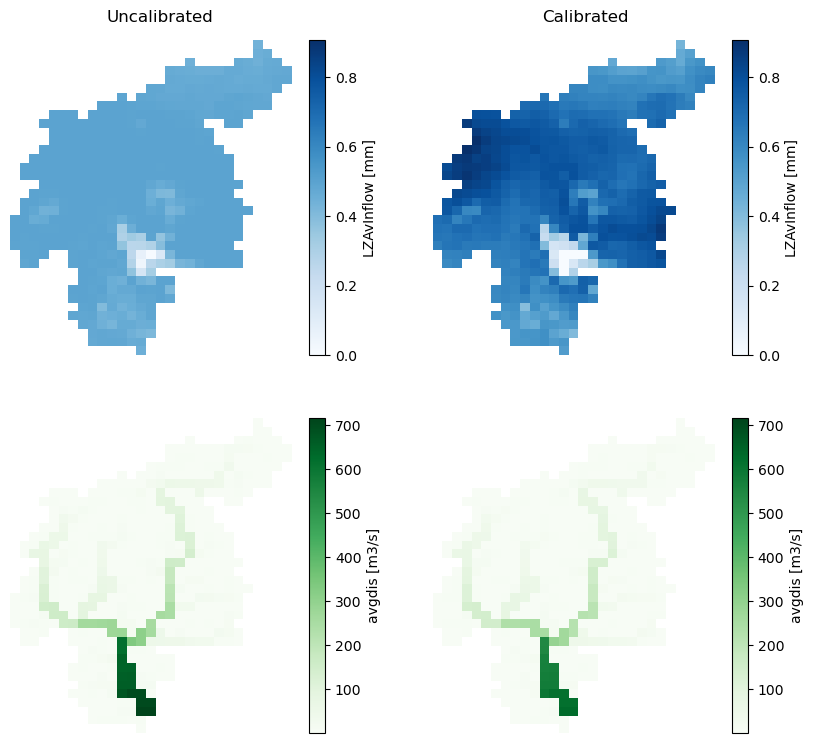

In [2]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 9))

for r, (var, cmap) in enumerate(zip(['lzavin', 'avgdis'], ['Blues', 'Greens'])):
    non_calib = xr.open_dataarray(path_init / f'{var}.nc')
    non_calib.close()
    calib = xr.open_dataarray(path_init / 'calibrated' / f'{var}.nc')
    calib.close()
    
    vmin = min(non_calib.min(), calib.min())
    vmax = max(non_calib.max(), calib.max())
    
    for c, da in enumerate([non_calib, calib]):
        da.plot(ax=ax[r, c], cmap=cmap, vmin=vmin, vmax=vmax)
        ax[r, c].axis('off')
        
fig.text(.275, .9, 'Uncalibrated', fontsize=12, horizontalalignment='center')
fig.text(.7, .9, 'Calibrated', fontsize=12, horizontalalignment='center');

***Figure 1**. Output maps from the initialization run: average inflow into the lower groundwater zone (LZAvin) and average river discharge (avgdis). The left column corresponds to the initialization with default parameters, and the right column to the initialization with calibrated parameters.*

In our study case, the change in the _lzavin_ is notorious.

## 3 Warmup

As explained in [Chapter 3 - Warmup](2_warmup.ipynb), the objective of this run is to find the initial conditions at the begining of the target run. The usual output of these simulation is a set of maps (NetCDF) with the model state variables at the end of the simulation. For educational purposes, we chose to write, not only the end state maps, but also the map stack of one of the state variables: the lower groundwater zone.

To run this simulation, open a terminal and follow these steps:

```shell
conda activate <your_lisflood_environment>
cd <path_where_you_saved_the_repository>/lisflood-usecases
lisflood LF_mekong_usecase/settings_calibrated_warmup.xml
```

Let's see how some of the outputs of this run have changed with the calibrated parameters and the new initialization maps.

### 3.1 End maps

The following figure compares the end state maps of the warmup run with default parameters (_uncalibrated_) and the run with calibrated parameters (_calibrated_). Only five state variables are shown, the three soil layers (blue) and the two groundwater zones (green).

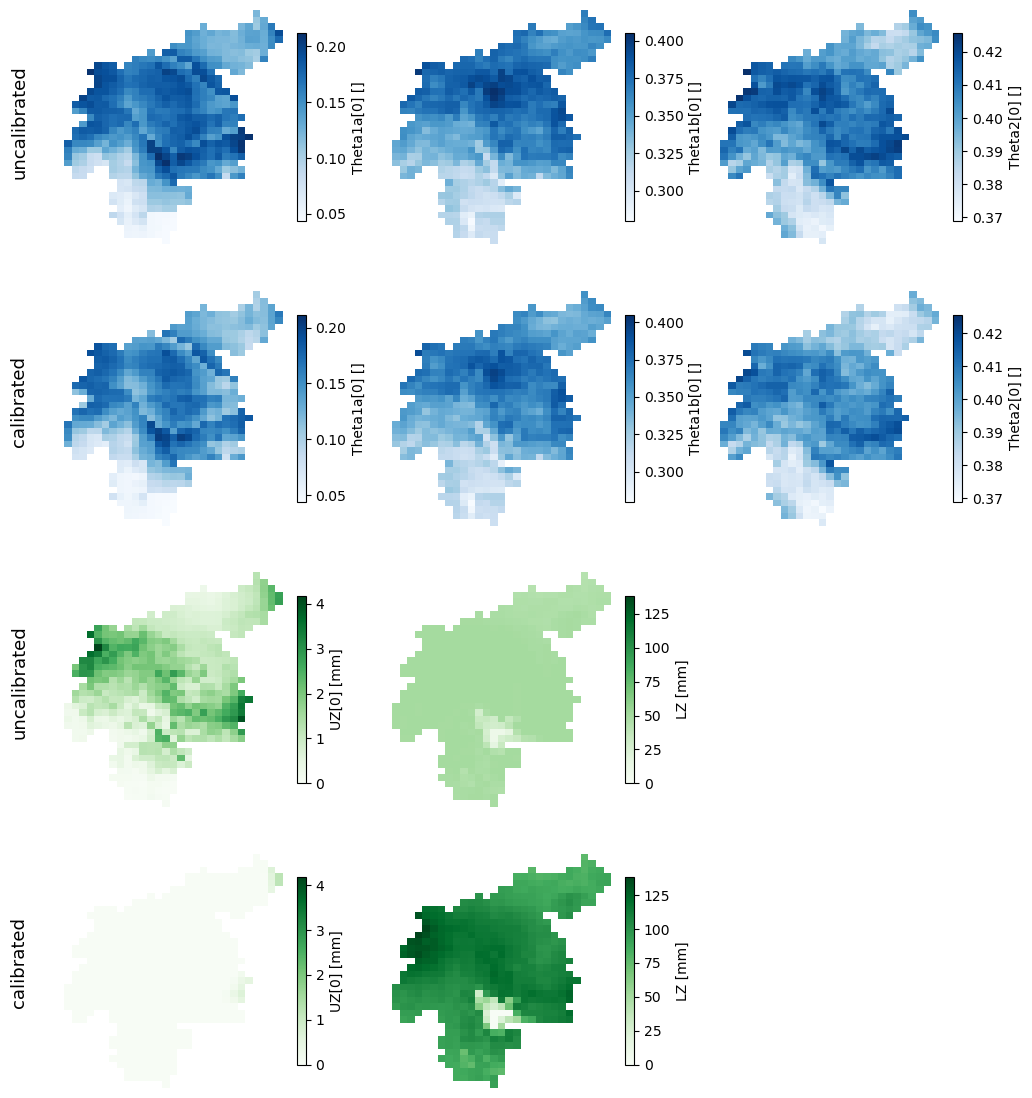

In [3]:
# load some end state maps (initial conditions for the run)
init_cond = {'uncalibrated': {}, 'calibrated': {}}
vmin, vmax = np.nan, np.nan
for var in ['tha', 'thb', 'thc', 'uz', 'lz']:
    da = xr.open_dataarray(path_warmup /  f'{var}_end.nc')
    da.close()
    init_cond['uncalibrated'][var] = da
    da = xr.open_dataarray(path_warmup / 'calibrated' / f'{var}_end.nc')
    da.close()
    init_cond['calibrated'][var] = da

# plot end state maps
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(12, 14))
plot_config = {
    'soil': {
        'vars': ['tha', 'thb', 'thc'], 
        'cmap': 'Blues'
    },
    'groudwater': {
        'vars': ['uz', 'lz'], 
        'cmap': 'Greens'
    }
}
for g, (group, config) in enumerate(plot_config.items()):
    for col, var in enumerate(config['vars']):
        # calculate minimum and maximum values for the colorbar
        vmin = min([init_cond[sim][var].min() for sim in ['uncalibrated', 'calibrated']])
        vmax = max([init_cond[sim][var].max() for sim in ['uncalibrated', 'calibrated']])
        for s, sim in enumerate(['uncalibrated', 'calibrated']):
            # plot the map
            row = g * 2 + s
            init_cond[sim][var].plot(
                ax=ax[row, col], 
                cmap=config['cmap'], 
                vmin=vmin, 
                vmax=vmax,
                cbar_kwargs={'shrink': 0.8},
            )
            ax[row, col].axis('off')
            if col < 2:
                for c in range(col + 1, 3):
                    ax[row, c].axis('off')
            # add title to each row
            if col == 0:
                fig.text(.08, .8 - .2 * row, sim, fontsize=13, rotation=90, verticalalignment='center');

***Figure 2**. Initial conditions in the soil (blue) and groundwater (green) layers. In each of the groups of variables, the top row corresponds to the initial conditions with default parameters, and the bottom row to the initial conditions with calibrated parameters.*

In our study case, the initial conditions of the soil layers have not changed significantly, but those of the groundwater zone are clearly different.

### 3.2 Lower groundwater zone

In the previous figure we saw that the state of the lower groundwater zone is very different with the new calibrated warmup run. Since we have created the map stack for this variable, we can dig deeper into the differences between this warmup run with calibrated parameters and the the previous warmup run with default parameters.

The following figure shows the timeseries of the average lower groundwater storage (catchment mean) in both warmup runs. 

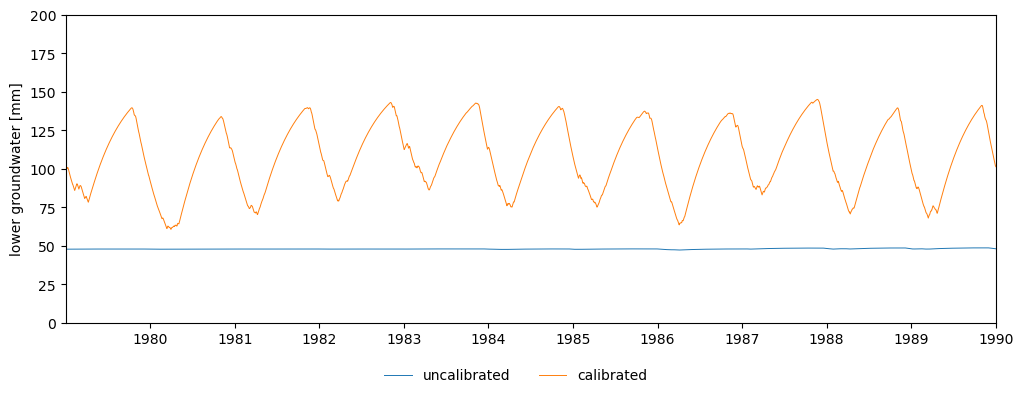

In [4]:
# load map stack for the uncalibrated warmup
lz = xr.open_dataarray(path_warmup / 'lz.nc')
lz.close()

# load map stack for the calibrated warmup
lz_cal = xr.open_dataarray(path_warmup / 'calibrated' / 'lz.nc')
lz_cal.close()

# plot comparison
fig, ax = plt.subplots(figsize=(12, 4))
lz.mean(['lat', 'lon']).plot(ax=ax, lw=.7, label='uncalibrated')
lz_cal.mean(['lat', 'lon']).plot(ax=ax, lw=.7, label='calibrated')
ax.set(
    xlim=(lz.time.data[0], lz.time.data[-1]),
    xlabel=None,
    ylim=(0, 200),
    ylabel='lower groundwater [mm]',
    title=''
)
fig.legend(loc=8, ncol=4, bbox_to_anchor=[0.45, -0.07, .1, .1], frameon=False);

***Figure 3**. Evolution of the amount of water stored in the lower groundwater zone during the warmup run.*

## 4 Run

The previous figures were meant only to explain why the initialization and warmup simulations need to be rerun with the new calibrated parameters. If we didn't, neither the initialization maps nor the initial conditions would correspond to the behaviour of the calibrated model, which would cause a strange model output at the beginning of the target run.

Now we are in a position to run our target simulation with a correct initialization and a calibrated model. To do so, open a terminal a follow these steps:

```shell
conda activate <your_lisflood_environment>
cd <path_where_you_saved_the_repository>/lisflood-usecases
lisflood LF_mekong_usecase/settings_calibrated_run.xml
```

The following figure compares the discharge simulated at the catchment outlet by both the uncalibrated and the calibrated models.

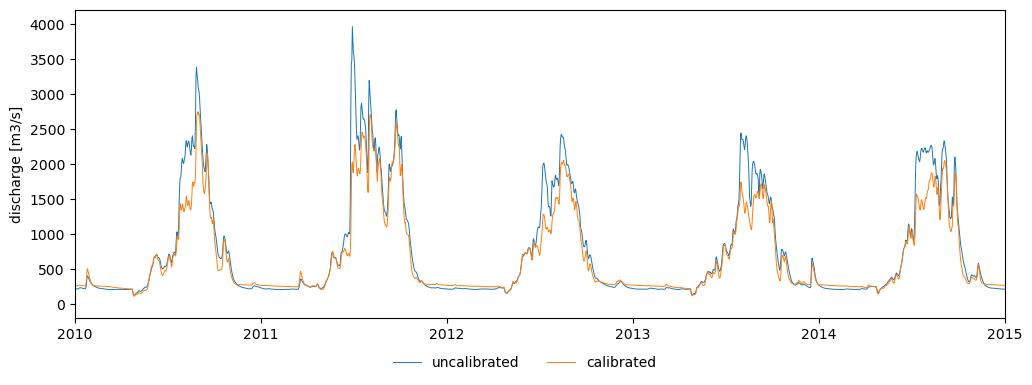

In [5]:
# settings files for the main run with default or calibrated parameters
settings = path_model / 'settings_run.xml'
settings_cal = path_model / 'settings_calibrated_run.xml'

# import non-calibrated discharge timeseries
dis = read_tss(path_run / 'disWin.tss', xml=settings)

# import calibrated discharge timeseries
dis_cal = read_tss(path_run / 'calibrated' / 'disWin.tss', xml=settings_cal)

# plot timeseries
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dis.iloc[:,-1], lw=.7, label='uncalibrated')
ax.plot(dis_cal.iloc[:,-1], lw=.7, label='calibrated')
ax.set(
    xlim=(datetime(2010, 1, 1), datetime(2015, 1, 1)),
    ylim=(-200, 4200),
    ylabel='discharge [m3/s]',
    title=''
)
fig.legend(loc=8, ncol=4, bbox_to_anchor=[0.45, -0.05, .1, .1], frameon=False);

***Figure 4**. River discharge at the catchment outlet with default (blue) or calibrated (orange) parameters.*

As we see, the results differ when we run the calibrated model. These differences may seem small in our case study, but it is extremely important to calibrate the model before extracting any conclusions from the model results.